# Introduction 

In this article we are going to discuss our work on predicting House Prices. This is a classic regression problem in which we aim to predict the selling price of a house given its attributes. The motivation in doing such analysis is to provide real estate firms accurate information about expected values of properties. After creating the seven models, we conduct an evaluation of each model by comparing its accuracy. This work is organized in the following way: 

1. Methodology
1. Understanding and cleaning the data
1. Linear Regression
1. Random Forests  
1. Suport Vector Machine
1. Gradient Boosting
1. Neural Network
1. Bagging

 


# Methodology


As we are dealing with a regression problem, an appropriate metric is the Root Mean Squared Error or RMSE. The methodology we followed is:

* Each method trained using 5-fold cross-validation.
* Final RMSE,R2 is calculated based on the average results of all training steps.   

Using cross-validation is a common way to assess the predictive performance of the models and to judge how they perform outside the sample (and assess their generalization strength).  


# Understanding and cleaning the data
Much of the work in making a good model is contingent on a good feature preparation process. This phase encompasses tasks such as: cleaning, feature mapping, feature selection, and feature scaling. In this section we describe the steps we did to get a better understanding of the data and to make it more appropriate for modeling analysis.


## The data set

The house prices [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 
has 81 features and the objective is to predict SalePrice. 

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import warnings
from scipy.stats import norm
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline
    
data_train = pd.read_csv("train.csv",na_values=['?',''],delimiter=',',delim_whitespace=False) # reading data from files
#data_test = pd.read_csv("test.csv",na_values=['?',''],delimiter=',',delim_whitespace=False)

print(data_train.shape)

#print(data_test.shape)


(1460, 81)


## Exploring the dataset

Understanding the data is an important part of our project. The more we understand the data the more we will have the ability to accuratley select and manupilate the features to get the best possible results. In this section we explore possible correlations between the dependent and the independent variables (Figure 1). Linear regression models are sensitive to non-linearity, outliers and colinearity, so we are going also to check these potential problems. 

In [2]:
data_train.info()
#data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Missing values

Maybe the most common problem in real datasets is the missing values. Sometimes, instead of a blank space, a wildcard is used like '?' or 'NA'. In this project, in addition to the missing values we also have some 'NAs' used to denote the absence of features. To solve this issue, whenever appropriate we replace 'NA' by the value 'No'.


In [3]:
#checking for null values
print(data_train.columns[data_train.isnull().any()])
print(len(data_train.columns[data_train.isnull().any()]))
#print(data_test.columns[data_test.isnull().any()])
#print(len(data_test.columns[data_test.isnull().any()]))

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')
19


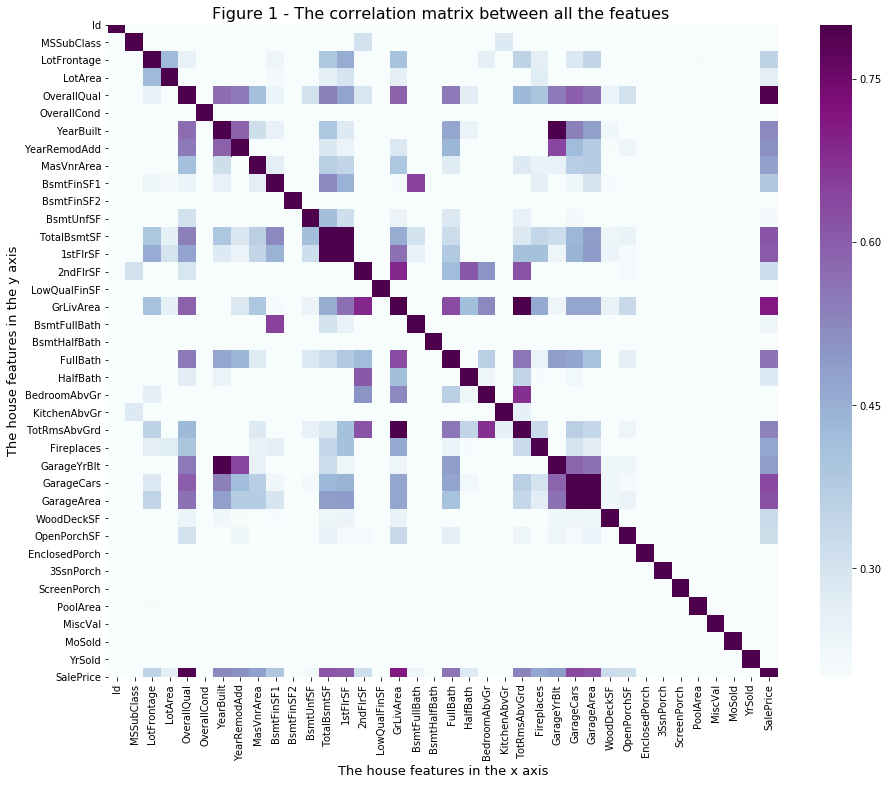

In [4]:
#for i in data_train.columns:
#    if data_train[i].isnull().any():
#        print(i,data_train[i].dtype)      

numerical_data = data_train.select_dtypes(exclude =['object'])
corr_matrix = numerical_data.corr()
f, ax = plt.subplots( figsize=(15, 12))
sns.heatmap(corr_matrix,vmin=0.2, vmax=0.8, square= True, cmap= 'BuPu')
plt.xlabel('The house features in the x axis',fontsize= 13)
plt.ylabel('The house features in the y axis',fontsize= 13)
plt.title('Figure 1 - The correlation matrix between all the featues ', fontsize= 16);
        

We can notice that some variables are strongly correlated with SalePrice. Specifically, these six features : OverallQual, GrlivArea, TotalBsmtSF, 1stFLrSF, GarageCars, and GrageArea. Moreover, some variables are strongly correlated with each other which means that we might have a multicollinearity. Subsequently, we need to take them into consideration when selecting and preparing the features to use in our modelling. For example there is a strong correlation between Yearbuilt and GarageYrBlt which means that most Garages are built in the same time with the construction of the houses.Therefeore,we can consider that Yearbuilt and GarageYrBlt as the same variable.
The correlation matrix shows only the value of the correlation but it doesn't reveal the nature of the correaltion. On the other hand scatter or some other charts can show the nature of the correlation whether it is linear or has another shape.

### Scatter plot of the most correlated features with SalePrice

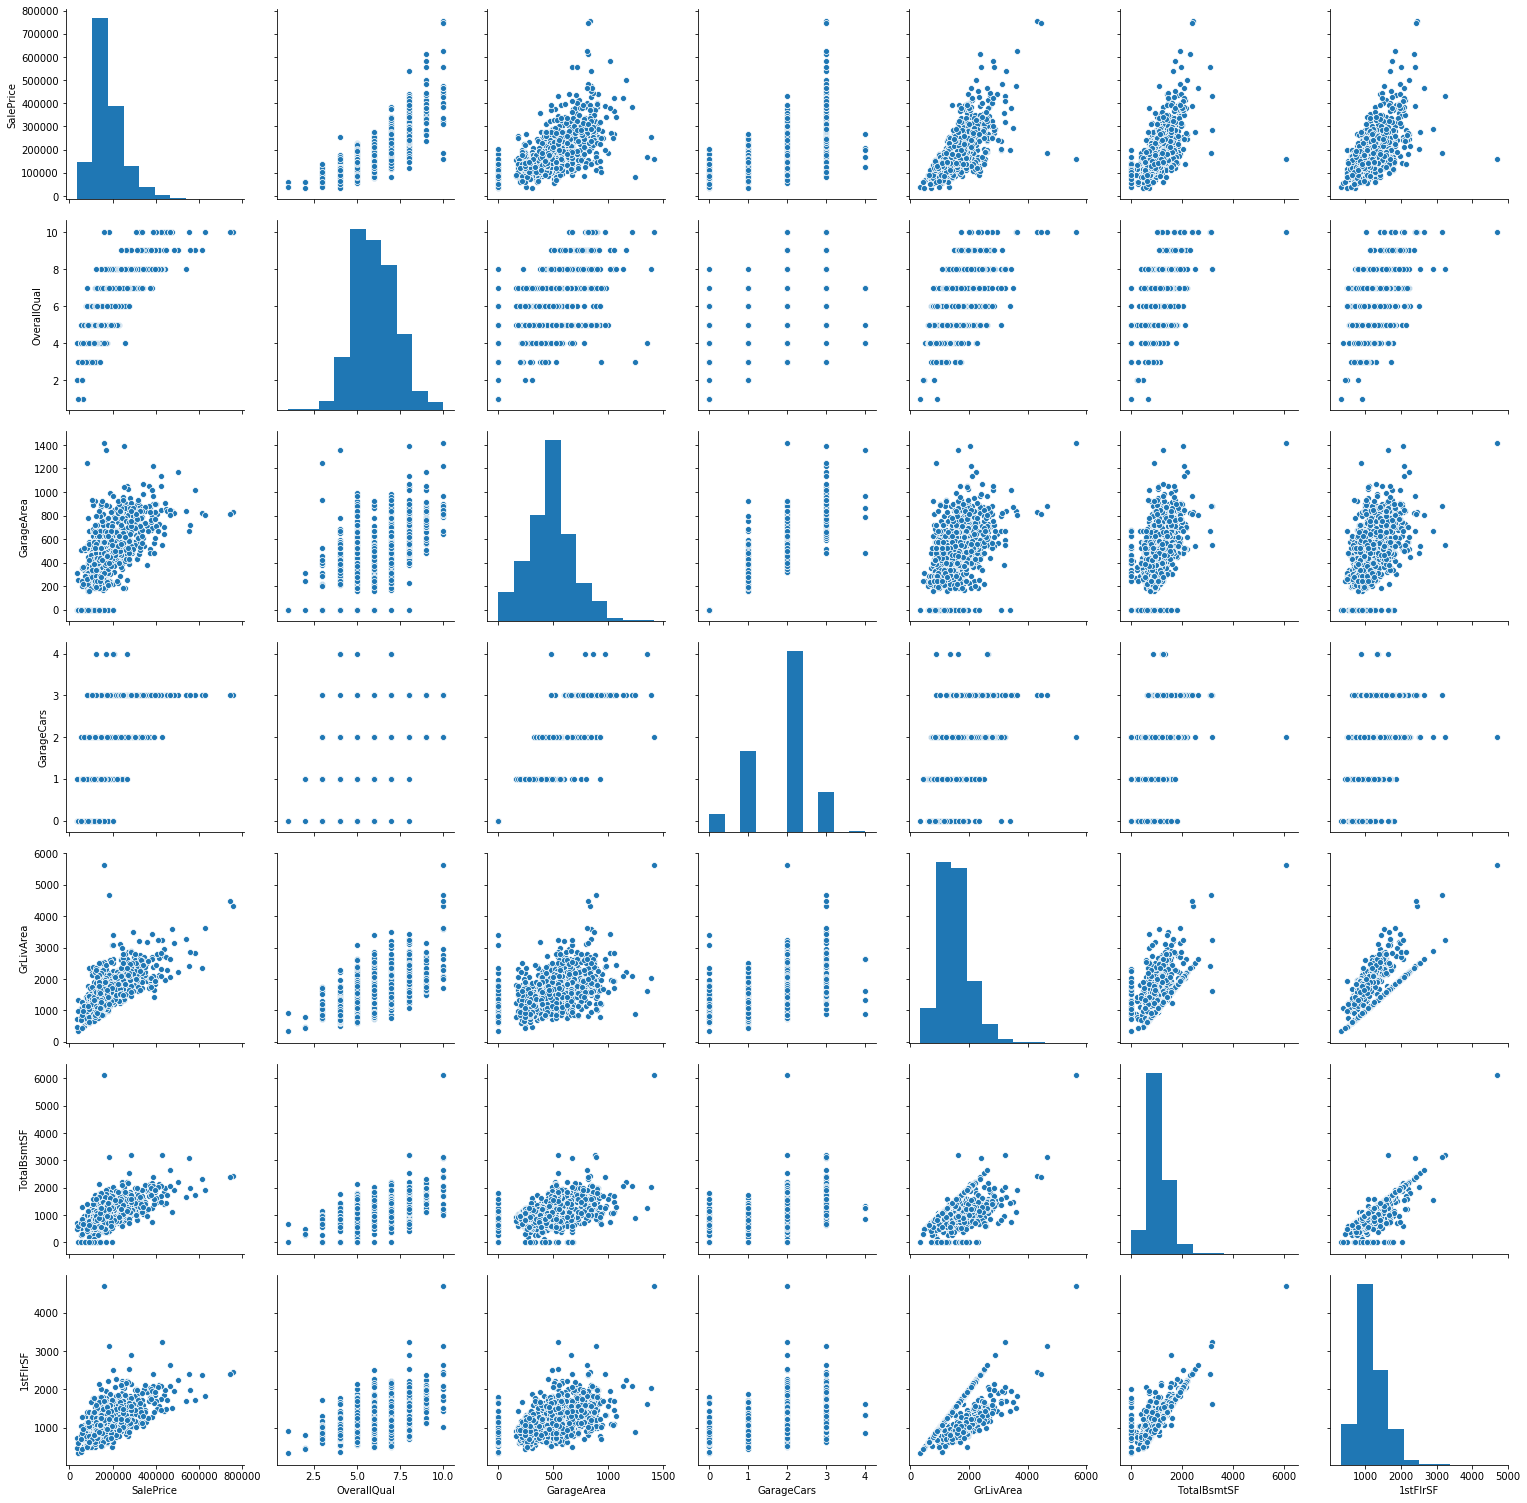

In [5]:
#['OverallQual' 'GarageCars' 'GrLivArea' 'FullBath' 'YearBuilt'
# 'GarageArea' 'TotalBsmtSF' '1stFlrSF' 'KitchenQual' 'BsmtQual']
cols =['SalePrice','OverallQual','GarageArea','GarageCars','GrLivArea','TotalBsmtSF', '1stFlrSF']

sns.pairplot(data_train[cols], size =3)

Figure 2 shows that there are two plots wich exhibit some kind of outliers: TotalBamtSF and GrLivArea. So we need to take a close look into them and decide whether we have outliers or not.

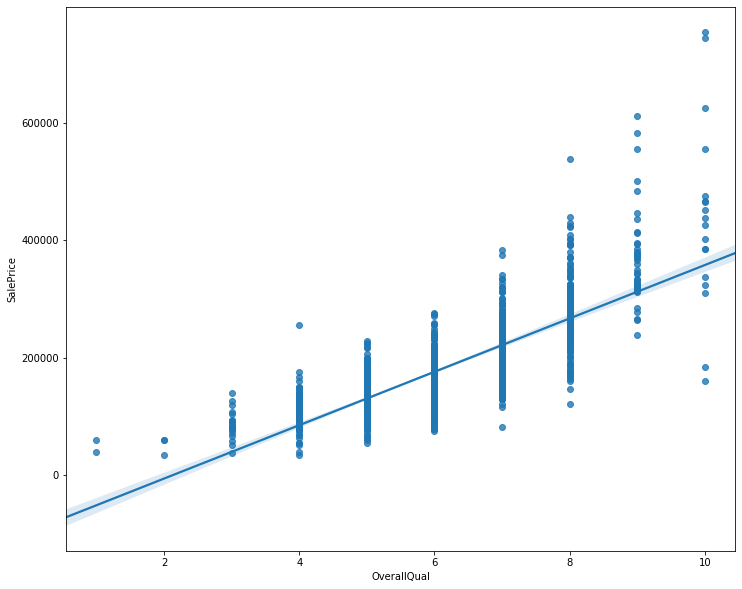

In [6]:
plt.figure(figsize =(12,10));
sns.regplot(x='OverallQual',y='SalePrice',data=data_train)

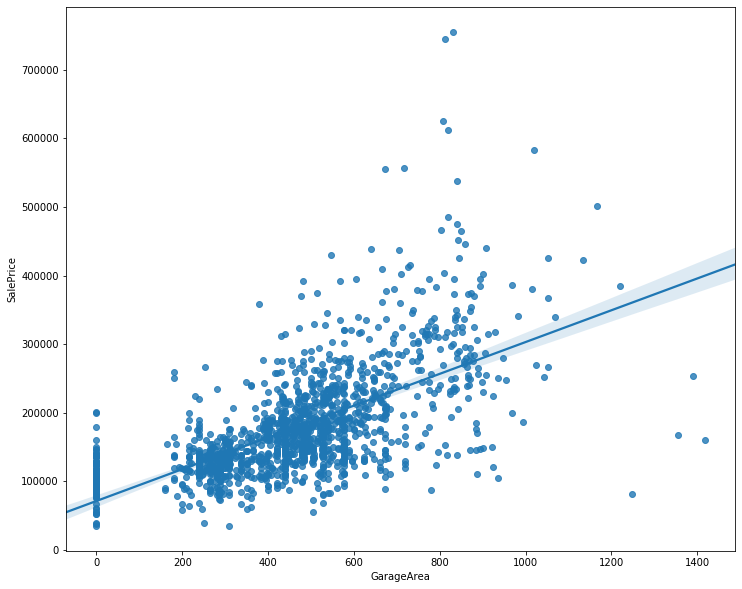

In [7]:
plt.figure(figsize =(12,10));
sns.regplot(x='GarageArea',y='SalePrice',data=data_train)

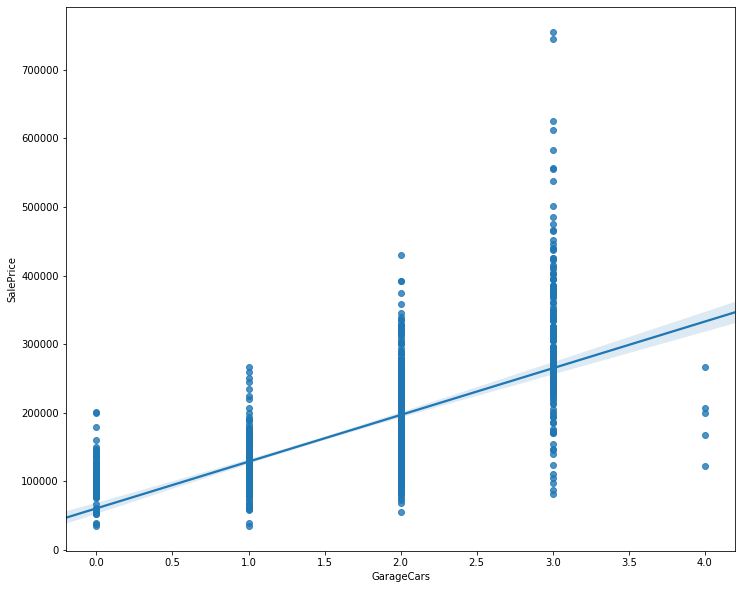

In [8]:
plt.figure(figsize =(12,10));
sns.regplot(x='GarageCars',y='SalePrice',data=data_train)

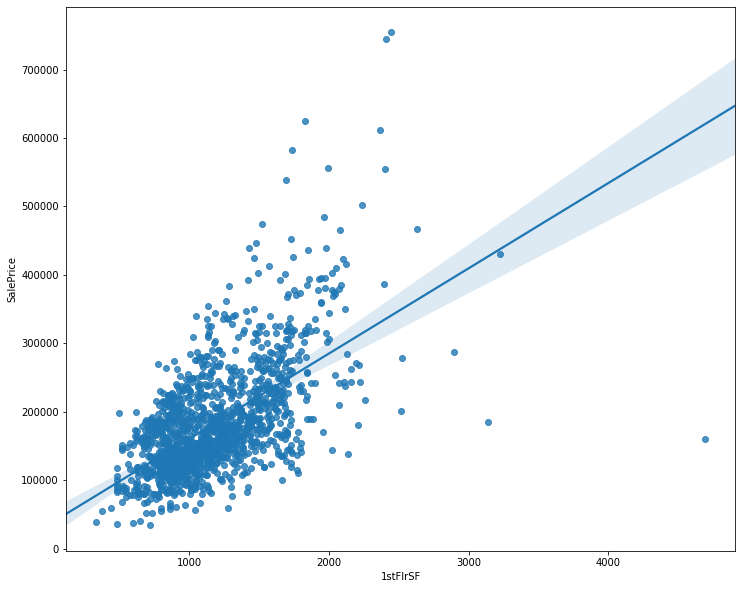

In [9]:
plt.figure(figsize =(12,10));
sns.regplot(x='1stFlrSF',y='SalePrice',data=data_train)

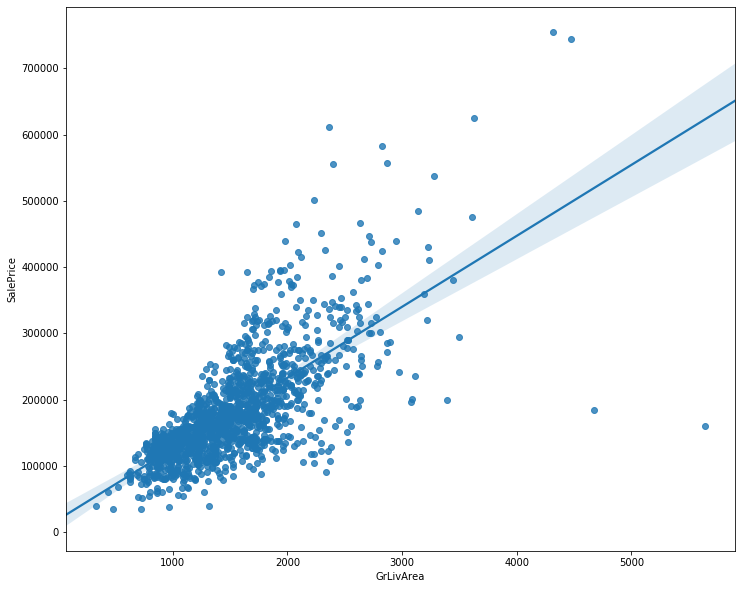

In [10]:
plt.figure(figsize =(12,10));
sns.regplot(x='GrLivArea',y='SalePrice',data=data_train)

In [11]:
g_out = data_train.sort_values(by="GrLivArea", ascending = False).head(2)
g_out

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [12]:
data_train.drop([523,1298], inplace = True)
data_train.reset_index(inplace=True)

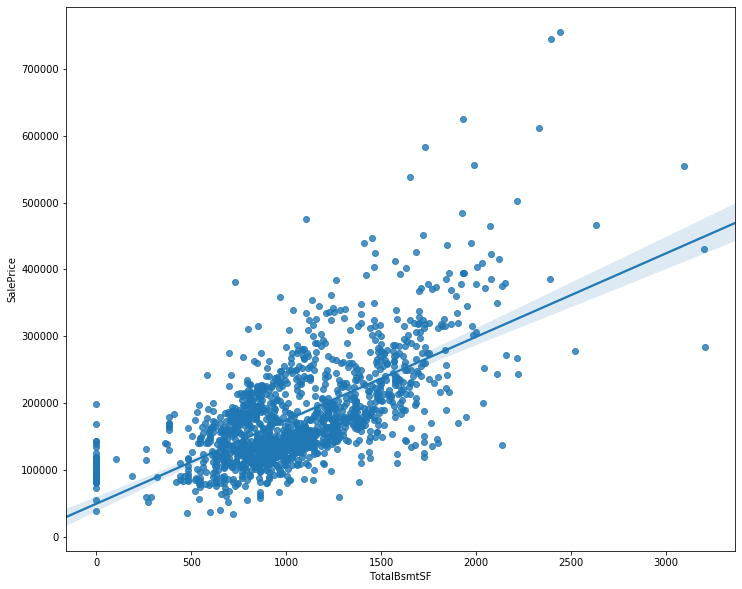

In [13]:
plt.figure(figsize =(12,10));
sns.regplot(x='TotalBsmtSF',y='SalePrice',data=data_train)

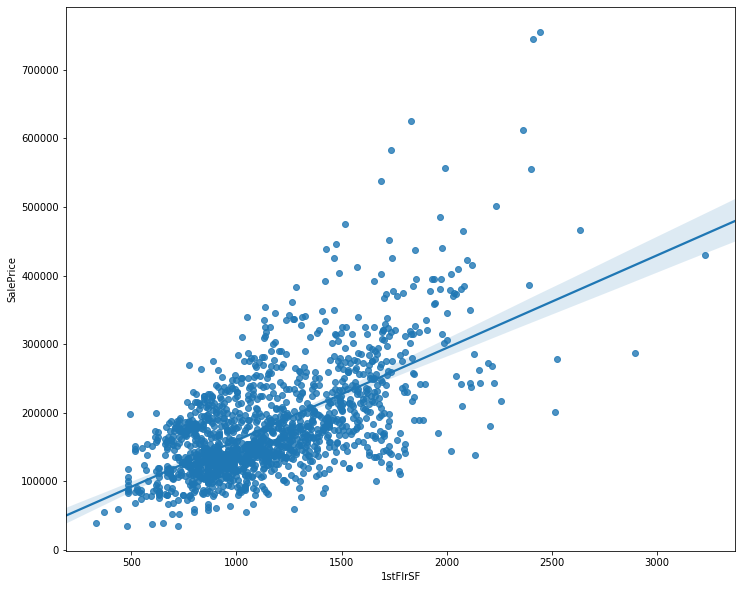

In [14]:
plt.figure(figsize =(12,10));
sns.regplot(x='1stFlrSF',y='SalePrice',data=data_train)

Here we are going to replace the 'NA' values in the dataset using the DataFrame's built in method of Forward Fill, and then replacing the rest of the values using 'No' in plce of 'NA'


In [15]:
data_train.fillna(method="ffill",inplace=True)

In [16]:
arr=[]
for i in data_train.columns:
    if isinstance(i,object):
        if data_train[i].isnull().any():
            arr.append(i)
            
print(arr)

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [17]:
for i in arr:
    data_train[i].fillna(inplace=True,value='No')

In [18]:
for i in data_train.columns:
    if isinstance(i,object):
        if data_train[i].isnull().any():
            print(i)

Here we are finding out the object datatypes in the Dataset and converting them to integer values.



In [19]:
object_data_train=data_train.select_dtypes(include =['object'])
for i in object_data_train:
    print(i,data_train[i].unique(),"\t",len(data_train[i].unique()),"\n")

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH'] 	 5 

Street ['Pave' 'Grvl'] 	 2 

Alley ['No' 'Grvl' 'Pave'] 	 3 

LotShape ['Reg' 'IR1' 'IR2' 'IR3'] 	 4 

LandContour ['Lvl' 'Bnk' 'Low' 'HLS'] 	 4 

Utilities ['AllPub' 'NoSeWa'] 	 2 

LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 	 5 

LandSlope ['Gtl' 'Mod' 'Sev'] 	 3 

Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 	 25 

Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 	 9 

Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosA' 'PosN' 'RRAn' 'RRAe'] 	 8 

BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 	 5 

HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 	 8 

RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed'] 	 6 

RoofMatl ['CompShg' 'WdShngl' 'Me

In [20]:
object_data_train=data_train.select_dtypes(include =['object'])
for i in object_data_train:
    data_train[i] = data_train[i].factorize()[0]+1
    print(i,np.unique(data_train[i]))

MSZoning [1 2 3 4 5]
Street [1 2]
Alley [1 2 3]
LotShape [1 2 3 4]
LandContour [1 2 3 4]
Utilities [1 2]
LotConfig [1 2 3 4 5]
LandSlope [1 2 3]
Neighborhood [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Condition1 [1 2 3 4 5 6 7 8 9]
Condition2 [1 2 3 4 5 6 7 8]
BldgType [1 2 3 4 5]
HouseStyle [1 2 3 4 5 6 7 8]
RoofStyle [1 2 3 4 5 6]
RoofMatl [1 2 3 4 5 6 7]
Exterior1st [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exterior2nd [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
MasVnrType [1 2 3 4]
ExterQual [1 2 3 4]
ExterCond [1 2 3 4 5]
Foundation [1 2 3 4 5 6]
BsmtQual [1 2 3 4]
BsmtCond [1 2 3 4]
BsmtExposure [1 2 3 4]
BsmtFinType1 [1 2 3 4 5 6]
BsmtFinType2 [1 2 3 4 5 6]
Heating [1 2 3 4 5 6]
HeatingQC [1 2 3 4 5]
CentralAir [1 2]
Electrical [1 2 3 4 5]
KitchenQual [1 2 3 4]
Functional [1 2 3 4 5 6 7]
FireplaceQu [1 2 3 4 5 6]
GarageType [1 2 3 4 5 6]
GarageFinish [1 2 3]
GarageQual [1 2 3 4 5]
GarageCond [1 2 3 4 5]
PavedDrive [1 2 3]
PoolQC [1 2

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 82 columns):
index            1458 non-null int64
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1458 non-null int64
LotFrontage      1458 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null int64
Alley            1458 non-null int64
LotShape         1458 non-null int64
LandContour      1458 non-null int64
Utilities        1458 non-null int64
LotConfig        1458 non-null int64
LandSlope        1458 non-null int64
Neighborhood     1458 non-null int64
Condition1       1458 non-null int64
Condition2       1458 non-null int64
BldgType         1458 non-null int64
HouseStyle       1458 non-null int64
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null int64
RoofMatl         1458 non-null int64
Ext

# Feature selection

Feature selection is the task of trying to discover the smallest set of features highly correlated with the dependent variable. It is important for the interpretability of the model but also to get a better fit, and consequently a better performance. We employed an automatic feature selection technique using a tree-based learning algorithm, and then used the tree structure produced to select the best features.  

In [22]:
print("\nFeatures \n")

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel


#Tree-based feature selection

x_train = data_train.drop('SalePrice',axis=1)
y_train = data_train['SalePrice']
clf = ExtraTreesRegressor(n_estimators=20)
clf = clf.fit(x_train,y_train)
data = np.zeros((1,x_train.shape[1])) 
data = pd.DataFrame(data, columns=x_train.columns)
data.iloc[0] = clf.feature_importances_
data = data.T.sort_values(data.index[0], ascending=False).T

print("Features selected with Tree-based selection \n")
column_names = np.asarray((data.columns[0:40]))
column_revelence = np.asarray((data.iloc[:,0:40]))
print(column_names)
print("\n Relevance of each feature \n")
print(column_revelence)


Features 

Features selected with Tree-based selection 

['OverallQual' 'GarageCars' 'GrLivArea' '1stFlrSF' 'TotalBsmtSF'
 'GarageArea' 'ExterQual' 'FullBath' 'BsmtQual' 'YearBuilt' 'YearRemodAdd'
 'TotRmsAbvGrd' 'Fireplaces' '2ndFlrSF' 'KitchenQual' 'BsmtFinSF1'
 'LotArea' 'CentralAir' 'MasVnrArea' 'Foundation' 'BedroomAbvGr'
 'MSZoning' 'BsmtFullBath' 'OverallCond' 'WoodDeckSF' 'GarageType'
 'HalfBath' 'SaleType' 'LotShape' 'Neighborhood' 'MSSubClass' 'LandSlope'
 'BsmtExposure' 'SaleCondition' 'GarageYrBlt' 'LandContour' 'Fence'
 'OpenPorchSF' 'LotFrontage' 'BsmtUnfSF']

 Relevance of each feature 

[[0.31518794 0.0888588  0.07658496 0.05504494 0.05320934 0.04859203
  0.04502909 0.02695147 0.02436634 0.02276044 0.01822168 0.01789845
  0.01703089 0.01657496 0.0162962  0.0150538  0.00724085 0.00715094
  0.00625997 0.00619293 0.00543352 0.00453236 0.00450944 0.00438286
  0.00401858 0.0037094  0.0033688  0.00327121 0.0032563  0.00323678
  0.00317864 0.00286963 0.0028688  0.00251575 0.0

In [23]:
print(column_names)
data_aux = pd.DataFrame(data=x_train, columns=column_names)
data_aux.to_csv('preprocessedData.csv', index=False)

['OverallQual' 'GarageCars' 'GrLivArea' '1stFlrSF' 'TotalBsmtSF'
 'GarageArea' 'ExterQual' 'FullBath' 'BsmtQual' 'YearBuilt' 'YearRemodAdd'
 'TotRmsAbvGrd' 'Fireplaces' '2ndFlrSF' 'KitchenQual' 'BsmtFinSF1'
 'LotArea' 'CentralAir' 'MasVnrArea' 'Foundation' 'BedroomAbvGr'
 'MSZoning' 'BsmtFullBath' 'OverallCond' 'WoodDeckSF' 'GarageType'
 'HalfBath' 'SaleType' 'LotShape' 'Neighborhood' 'MSSubClass' 'LandSlope'
 'BsmtExposure' 'SaleCondition' 'GarageYrBlt' 'LandContour' 'Fence'
 'OpenPorchSF' 'LotFrontage' 'BsmtUnfSF']


In [24]:
data_aux["SalePrice"] = y_train
data_aux.to_csv('preprocessedData.csv', index=False)

In [25]:
data = pd.read_csv('preprocessedData.csv')
data

,OverallQual,GarageCars,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,ExterQual,FullBath,BsmtQual,YearBuilt,...,LandSlope,BsmtExposure,SaleCondition,GarageYrBlt,LandContour,Fence,OpenPorchSF,LotFrontage,BsmtUnfSF,SalePrice
0,7,2,1710,856,856,548,1,2,1,2003,...,1,1,1,2003.0,1,1,61,65.0,150,208500
1,6,2,1262,1262,1262,460,2,2,1,1976,...,1,2,1,1976.0,1,1,0,80.0,284,181500
2,7,2,1786,920,920,608,1,2,1,2001,...,1,3,1,2001.0,1,1,42,68.0,434,223500
3,7,3,1717,961,756,642,2,1,2,1915,...,1,1,2,1998.0,1,1,35,60.0,540,140000
4,8,3,2198,1145,1145,836,1,2,1,2000,...,1,4,1,2000.0,1,1,84,84.0,490,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,6,2,1647,953,953,460,2,2,1,1999,...,1,1,1,1999.0,1,3,40,62.0,953,175000
1454,6,2,2073,2073,1542,500,2,2,1,1978,...,1,1,1,1978.0,1,2,0,85.0,589,210000
1455,7,1,2340,1188,1152,252,3,2,2,1941,...,1,1,1,1941.0,1,4,60,66.0,877,266500
1456,5,1,1078,1078,1078,240,2,1,2,1950,...,1,3,1,1950.0,1,4,0,68.0,0,142125


In [26]:
processed_x_train = data.drop('SalePrice', axis=1)
processed_y_train = data['SalePrice']
print(processed_x_train)
print(processed_y_train)

      OverallQual  GarageCars  GrLivArea  1stFlrSF  TotalBsmtSF  GarageArea  \
0               7           2       1710       856          856         548   
1               6           2       1262      1262         1262         460   
2               7           2       1786       920          920         608   
3               7           3       1717       961          756         642   
4               8           3       2198      1145         1145         836   
...           ...         ...        ...       ...          ...         ...   
1453            6           2       1647       953          953         460   
1454            6           2       2073      2073         1542         500   
1455            7           1       2340      1188         1152         252   
1456            5           1       1078      1078         1078         240   
1457            5           1       1256      1256         1256         276   

      ExterQual  FullBath  BsmtQual  YearBuilt  ...

### Transforming non-linear data into linear data

We are going to start with verifying whether the data is linear or not. To do this in a multiple linear regression model we plot the residuals against the predicted values. The results are shown in
Figure 3. 

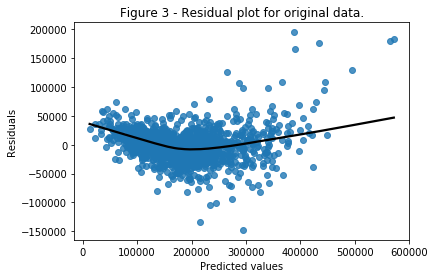

Mean square error:  743856969.8983614


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import statsmodels.api as sm

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

scaler = preprocessing.StandardScaler()
x_train_s = scaler.fit_transform(x_train)   

linear1 = LinearRegression()
linear1.fit(x_train_s, y_train)
pred = linear1.predict(x_train_s)
ax = sns.regplot(x=pred,y=y_train-pred,lowess=True,line_kws={"color":"black"})
ax.set_title('Figure 3 - Residual plot for original data.')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show();

print("Mean square error: ",sum(np.power((y_train-pred),2))/x_train.shape[0])

#results = sm.OLS(y_train,x_train_s).fit()
#print(results.summary())

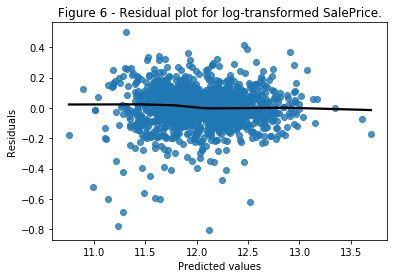

Mean square error:  0.01529044060838183


In [28]:
linear2 = LinearRegression()
linear2.fit(x_train_s, np.log1p(y_train))
pred = linear2.predict(x_train_s)
ax = sns.regplot(x=pred,y=np.log1p(y_train)-pred,lowess=True,line_kws={"color":"black"})
ax.set_title('Figure 6 - Residual plot for log-transformed SalePrice.')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()
print("Mean square error: ",sum(np.power((np.log1p(y_train)-pred),2))/x_train.shape[0])


data_train['SalePrice'] = np.log1p(data_train.SalePrice)

In [29]:
RMSE =  {
    'LinearRegression':[0.0],
    'RandomForest':[0.0],
    'SVM':[0.0],
    'GradientBoosting':[0.0],
    'NeuralNetwork':[0.0],
    'Bagging':[0.0],
}

R2 = {
    'LinearRegression':[0.0],
    'RandomForest':[0.0],
    'SVM':[0.0],
    'GradientBoosting':[0.0],
    'NeuralNetwork':[0.0],
    'Bagging':[0.0],   
}

## Linear Regression

In this section we are going to experiment with a set of regression methods in which the target value is expected to have a linear relationship with the input variables. 

###  Ordinary Least Squares

Least Square Error is a well known mathematical measure of the performance of a linear regression model. LSE works by changing the coefficients of the model in a way that minimize the sum of squares between the true values and the predicted values. It solves a problem of the form:   $\underset{w}{min\,} {|| X w - y||_2}^2$ 
and can be solved analyticaly by the equation

$$\hat\beta=(X^TX)^{-1}X^Ty$$

Where X is a matrix of the independents features, y is the actual response and $\hat\beta$ the estimated weights w. 

In [30]:
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn import preprocessing


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split


print("Linear Regression \n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierLinearRegression = LinearRegression(fit_intercept=True, normalize=False,
                                              copy_X=True, n_jobs=1)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierLinearRegression = classifierLinearRegression.fit(x_train_fold, y_train_fold)
    pred = classifierLinearRegression.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score))    
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['LinearRegression'] = score
R2['LinearRegression'] = r2

RMSE['LinearRegression'] 

Linear Regression 


 Average RMSE: 27273.74139897864

 R2 error: 0.8822103374823931


27273.74139897864

## Random Forest

Random Forest is one of the most versatile and precise classifier. It does not need the data being scaled and can deal with any number of features. In order to test the random forest algorithm a little further than the others, we decided to train it using different train sets. First, with a data set containing all the features and no scaling. Second, in the reduced train set with scaled features. 

As we can see in the results bellow, it did well in both cases. This test was also interesting to validate our set of selected features. Seems they are really good options once the performance using the the full set is not significatively better than using the restricted set. 

After some experimentation, the configuration we chose was: the number of trees is 500 as any greater value did not enhance the accuracy, MSE as the function to measure the quality of a split, max_depth with None which means the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples, max_features = auto to consider all the features when looking for the best split and bootstrap = True for replacement as it gave better results during the tests. All the others parameters were maintained in their default values.   

In [31]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split


print("RandomForest \n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierRandomFprest = RandomForestRegressor(n_estimators=500, criterion='mse', 
                max_depth=None, min_samples_split=2, min_samples_leaf=1,
                min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
                min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True,
                oob_score=False, n_jobs=1, random_state=0, verbose=0, warm_start=False)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierRandomFprest = classifierRandomFprest.fit(x_train_fold, y_train_fold)
    pred = classifierRandomFprest.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score)) 
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['RandomForest'] = score
R2['RandomForest'] = r2

RandomForest 


 Average RMSE: 9531.872355227366

 R2 error: 0.9856128697089355


## Support Vector Machine

SVM is a large margin classifier. The rationale behind having decision boundaries with large margins is that they tend to have a lower generalization error. Whereas, models with small margins are more
prone to overfitting. We can control the width of the margin using the regularization parameter C. Lower values of C give smaller margins and vice versa. 

We have used the linear kernel as it gave far the best result when comparing to rbf or sigmoid. It is a sign that a linear fit is well adjusted to the true data and also can explain that no regularization was necessary. The best value for C was 1. We kept the other parameters in their default values.

In [32]:
from sklearn.svm import SVR


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split

print("SVM\n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierSVM = SVR(kernel = 'linear', gamma='auto', coef0=0.0, tol=0.001)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierSVM = classifierSVM.fit(x_train_fold, y_train_fold)
    pred = classifierRandomFprest.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score))    
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['SVM'] = score
R2['SVM'] = r2

SVM


 Average RMSE: 9531.872355227366

 R2 error: 0.9856128697089355


## Gradient Boosting
Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

![title](GB.png)

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split


print("Gradient Boosting \n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierGradientBoost = GradientBoostingRegressor(n_estimators=500)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierGradientBoost = classifierGradientBoost.fit(x_train_fold, y_train_fold)
    pred = classifierRandomFprest.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score)) 
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['GradientBoosting'] = score
R2['GradientBoosting'] = r2

Gradient Boosting 


 Average RMSE: 9531.872355227366

 R2 error: 0.9856128697089355


## Multilayer Perceptron

Multi-layer Perceptron (MLP) is a supervised learning algorithm. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function for either classification or regression. 

The class we are using in our work is the MLPRegressor which implements a multi-layer perceptron that trains using backpropagation with no activation function in the output layer (uses the identity function as activation function). Therefore, it uses the square error as the loss function, and the output is a set of continuous values.

A one hidden layer MLP has a function in the form:$$f : R^D -> R^L$$ where D is the size of input vector x, and L is the size of the output vector f(x). 

We think this model the most difficult to find a good adjustment of complexity. We have tested some configurations and the best set of parameters was: learning rate of 0.001, a ReLu activation function for the hidden layers as this can speed up the learning process, a small value for the regularization parameter alpha of 0.0001 which means an agressive regularization and a net of three hidden layers with 80, 50 and 20 neurons respectively. Even so, it was not enough to get comparable results with the other models. 

In [34]:
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split


print("Neural Network\n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierMLP= MLPRegressor(hidden_layer_sizes=(100,50,20),random_state = 1)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierMLP = classifierMLP.fit(x_train_fold, y_train_fold)
    pred = classifierRandomFprest.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score)) 
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['NeuralNetwork'] = score
R2['NeuralNetwork'] = r2

Neural Network


 Average RMSE: 9531.872355227366

 R2 error: 0.9856128697089355


## Bagging

Bootstrap aggregating, also called bagging (from bootstrap aggregating), is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

![title](BG.png)

In [35]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn   import metrics
from sklearn.model_selection import train_test_split


print("Bagging\n")

x_train = processed_x_train.copy()
y_train = processed_y_train.copy()

#Cross validation
classifierBagging= BaggingRegressor(random_state = 1)
kf = KFold(5, random_state=7, shuffle=True)    
cv_y = []
cv_pred = []
fold = 0
pred = []

for training, test in kf.split(x_train):
    fold+=1    
    pred = []    
    
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    x_train_fold = scaler.fit_transform(x_train)
    x_test_fold = scaler.transform(x_train)

    y_train_fold = y_train
    y_test_fold = y_train
    
    classifierBagging = classifierBagging.fit(x_train_fold, y_train_fold)
    pred = classifierRandomFprest.predict(x_test_fold)
    cv_y.append(y_test_fold)
    cv_pred.append(pred)        

    
#Calculating the error.
cv_y = np.concatenate(cv_y)
cv_pred = np.concatenate(cv_pred)
score = np.sqrt(metrics.mean_squared_error(cv_y,cv_pred))
print("\n Average RMSE: {}".format(score)) 
r2 = metrics.r2_score(cv_y,cv_pred)
print("\n R2 error: {}".format(r2))

RMSE['Bagging'] = score
R2['Bagging'] = r2

Bagging


 Average RMSE: 9531.872355227366

 R2 error: 0.9856128697089355


In [36]:
print(RMSE)
print(R2)

{'LinearRegression': 27273.74139897864, 'RandomForest': 9531.872355227366, 'SVM': 9531.872355227366, 'GradientBoosting': 9531.872355227366, 'NeuralNetwork': 9531.872355227366, 'Bagging': 9531.872355227366}
{'LinearRegression': 0.8822103374823931, 'RandomForest': 0.9856128697089355, 'SVM': 0.9856128697089355, 'GradientBoosting': 0.9856128697089355, 'NeuralNetwork': 0.9856128697089355, 'Bagging': 0.9856128697089355}


([<matplotlib.axis.XTick at 0x2054805e3c8>,
 <a list of 6 Text xticklabel objects>)

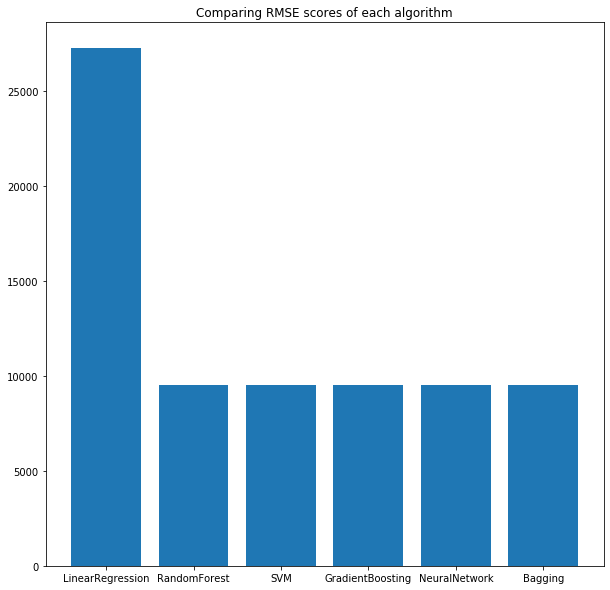

In [37]:
plt.figure(figsize=(10,10))
plt.title('Comparing RMSE scores of each algorithm')
plt.bar(range(len(RMSE)), list(RMSE.values()), align='center')
plt.xticks(range(len(RMSE)), list(RMSE.keys()))

([<matplotlib.axis.XTick at 0x2054d2a40c8>,
 <a list of 6 Text xticklabel objects>)

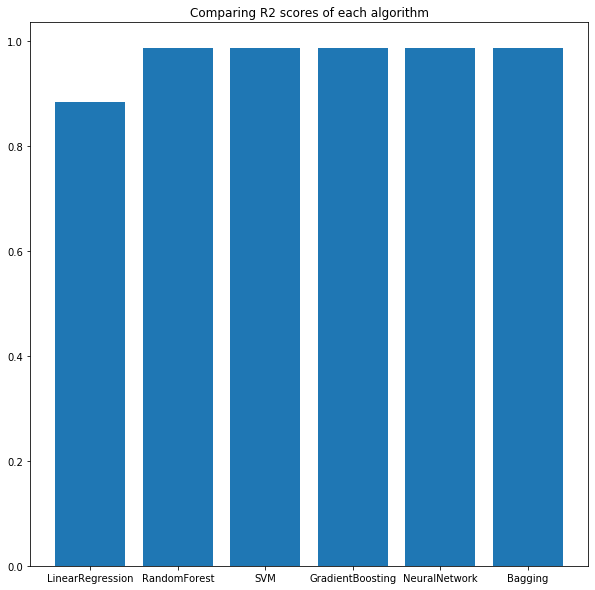

In [38]:
plt.figure(figsize=(10,10))
plt.title('Comparing R2 scores of each algorithm')
plt.bar(range(len(R2)), list(R2.values()), align='center')
plt.xticks(range(len(R2)), list(R2.keys()))
